In [210]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
from scipy.interpolate import interp2d
import os
import sys
from scipy.interpolate import griddata
import h5py
import time
import random
import datetime
from bma_merge import bma


def divide_train_test(data, dividenum, randseed=-1):
    if randseed == -1:
        random.seed(time.time())
    num = len(data)
    subnum = int(num / dividenum)
    data_train = np.zeros([dividenum, num - subnum], dtype=int)
    data_test = np.zeros([dividenum, subnum], dtype=int)
    randindex = random.sample(range(num), num)
    for i in range(dividenum):
        data_test[i, :] = np.sort(data[randindex[i * subnum:(i + 1) * subnum]])
        data_train[i, :] = np.setdiff1d(data, data_test[i])
    return data_train, data_test


def double_cvindex(gmet_stndatafile, dividenum, rndseed=123):
    # index for double cross-validation
    datatemp = np.load(gmet_stndatafile)
    prcp_stn0 = datatemp['prcp_stn'][:, 0]
    tmean_stn0 = datatemp['tmean_stn'][:, 0]
    prcp_stnindex = np.argwhere(~np.isnan(prcp_stn0))
    prcp_stnindex = prcp_stnindex.flatten()
    tmean_stnindex = np.argwhere(~np.isnan(tmean_stn0))
    tmean_stnindex = tmean_stnindex.flatten()

    subnum1 = int(len(prcp_stnindex) / dividenum)
    subnum2 = int((len(prcp_stnindex) - subnum1) / dividenum)
    # prcp_testindex1 = np.zeros([dividenum,subnum1])
    # prcp_trainindex1 = np.zeros([dividenum,len(prcp_stnindex) - subnum1])
    prcp_trainindex1, prcp_testindex1 = divide_train_test(prcp_stnindex, dividenum, randseed=rndseed)
    prcp_testindex2 = np.zeros([dividenum, dividenum, subnum2], dtype=int)
    prcp_trainindex2 = np.zeros([dividenum, dividenum, len(prcp_stnindex) - subnum1 - subnum2], dtype=int)
    for i in range(dividenum):
        traini, testi = divide_train_test(prcp_trainindex1[i, :], dividenum, randseed=rndseed)
        prcp_trainindex2[i, :, :] = traini
        prcp_testindex2[i, :, :] = testi

    subnum1 = int(len(tmean_stnindex) / dividenum)
    subnum2 = int((len(tmean_stnindex) - subnum1) / dividenum)
    # tmean_testindex1 = np.zeros([dividenum,subnum1])
    # tmean_trainindex1 = np.zeros([dividenum,len(tmean_stnindex) - subnum1])
    tmean_trainindex1, tmean_testindex1 = divide_train_test(tmean_stnindex, dividenum, randseed=rndseed)
    tmean_testindex2 = np.zeros([dividenum, dividenum, subnum2], dtype=int)
    tmean_trainindex2 = np.zeros([dividenum, dividenum, len(tmean_stnindex) - subnum1 - subnum2], dtype=int)
    for i in range(dividenum):
        traini, testi = divide_train_test(tmean_trainindex1[i, :], dividenum, randseed=rndseed)
        tmean_trainindex2[i, :, :] = traini
        tmean_testindex2[i, :, :] = testi
    return prcp_trainindex1, prcp_testindex1, prcp_trainindex2, prcp_testindex2, \
           tmean_trainindex1, tmean_testindex1, tmean_trainindex2, tmean_testindex2


def calculate_anomaly(datatar, dataref, hwsize, amode, upbound=5, lowbound=0.2):
    # datatar, dataref: 2D [nstn, ntime]
    # amode: anomaly mode ('ratio' or 'diff')
    # hwsize: define time window (2*hwsize+1) used to calculate ratio (as ratio for a specific day is too variable)
    # upbound/lowbound: upper and lower limitation of ratio/difference
    if np.ndim(datatar) == 1:  # only one time step
        datatar = datatar[:, np.newaxis]
        dataref = dataref[:, np.newaxis]

    nstn, ntime = np.shape(datatar)
    if ntime < hwsize * 2 + 1:
        print('The window size is larger than time steps when calculating ratio between tar and ref datasets')
        print('Please set a smaller hwsize')
        sys.exit()

    anom = np.ones([nstn, ntime])

    for i in range(ntime):
        if i < hwsize:
            windex = np.arange(hwsize * 2 + 1)
        elif i >= ntime - hwsize:
            windex = np.arange(ntime - hwsize * 2 - 1, ntime)
        else:
            windex = np.arange(i - hwsize, i + hwsize + 1)
        dtari = np.nanmean(datatar[:, windex], axis=1)
        drefi = np.nanmean(dataref[:, windex], axis=1)

        if amode == 'ratio':
            temp = drefi / dtari
            temp[(dtari == 0) & (drefi == 0)] = 1
            anom[:, i] = temp
        elif amode == 'diff':
            anom[:, i] = drefi - dtari
        else:
            sys.exit('Unknow amode. Please use either ratio or diff')

    anom[anom > upbound] = upbound
    anom[anom < lowbound] = lowbound
    return anom


def extrapolation(latin, lonin, datain, nearstn_loc, nearstn_dist):
    # datain: one or multiple time steps
    wexp = 3
    if np.ndim(datain) == 1:  # add time axis
        datain = datain[:, np.newaxis]
    latin[np.isnan(datain[:, 0])] = np.nan
    lonin[np.isnan(datain[:, 0])] = np.nan

    if np.ndim(nearstn_loc) == 2:  # extrapolate to station points
        num = np.shape(nearstn_loc)[0]
        ntimes = np.shape(datain)[1]
        dataout = np.zeros([num, ntimes])
        for i in range(num):
            dataini = datain[nearstn_loc[i, :], :]
            disti = nearstn_dist[i, :]
            weighti = au.distanceweight(disti, np.max(disti) + 1, wexp)
            weighti = weighti / np.sum(weighti)
            weighti2 = np.tile(weighti,[ntimes,1]).T
            dataout[i, :] = np.sum(dataini * weighti2, axis=0)
    elif np.ndim(nearstn_loc) == 3:  # extrapolate to gridds
        nrows, ncols, ntimes = np.shape(datain)
        dataout = np.zeros([nrows, ncols, ntimes])
        for r in range(nrows):
            for c in range(ncols):
                dataini = datain[nearstn_loc[r, c, :], :]
                disti = nearstn_dist[r, c, :]
                weighti = au.distanceweight(disti, np.max(disti) + 1, wexp)
                weighti = weighti / np.sum(weighti)
                weighti2 = np.tile(weighti, [ntimes, 1]).T
                dataout[r, c, :] = np.sum(dataini * weighti2, axis=0)
    else:
        print('The dimensions of tarlat or tarlon are larger than 2')
        sys.exit()

    return dataout


def findnearstn(stnlat, stnlon, tarlat, tarlon, nearnum, noself):
    # only use lat/lon to find near stations without considering distance in km
    # stnlat/stnlon: 1D
    # tarlat/tarlon: 1D or 2D
    # noself: 1--stnlat and tarlat have overlapped stations, which should be excluded from stnlat

    stnll = np.zeros([len(stnlat), 2])
    stnll[:, 0] = stnlat
    stnll[:, 1] = stnlon

    if len(np.shape(tarlat)) == 1:
        num = len(tarlat)
        nearstn_loc = np.nan * np.zeros([num, nearnum], dtype=int)
        nearstn_dist = np.nan * np.zeros([num, nearnum], dtype=float)
        for i in range(num):
            if np.isnan(tarlat[i]) or np.isnan(tarlon[i]):
                continue
            tari = np.array([tarlat[i], tarlon[i]])
            dist = au.distance(tari, stnll)
            dist[np.isnan(dist)] = 1000000000
            if noself == 1:
                dist[dist == 0] = np.inf  # may not be perfect, but work for SCDNA
            indi = np.argsort(dist)
            nearstn_loc[i, :] = indi[0:nearnum]
            nearstn_dist[i, :] = dist[nearstn_loc[i, :]]
    elif len(np.shape(tarlat)) == 2:
        nrows, ncols = np.shape(tarlat)
        nearstn_loc = np.nan * np.zeros([nrows, ncols, nearnum], dtype=int)
        nearstn_dist = np.nan * np.zeros([nrows, ncols, nearnum], dtype=float)
        for r in range(nrows):
            for c in range(ncols):
                if np.isnan(tarlat[r, c]) or np.isnan(tarlon[r, c]):
                    continue
                tari = np.array([tarlat[r, c], tarlon[r, c]])
                dist = au.distance(tari, stnll)
                dist[np.isnan(dist)] = 1000000000
                indi = np.argsort(dist)
                nearstn_loc[r, c, :] = indi[0:nearnum]
                nearstn_dist[r, c, :] = dist[nearstn_loc[r, c, :]]
    else:
        print('The dimensions of tarlat or tarlon are larger than 2')
        sys.exit()

    return nearstn_loc, nearstn_dist


def error_correction(dataori, anomaly, mode='ratio'):
    # default: time is the last dimension
    if mode == 'ratio':
        datacorr = dataori * anomaly
    elif mode == 'diff':
        datacorr = dataori + anomaly
    else:
        sys.exit('Wrong error correction mode')
    return datacorr


def calweight(obsall, preall, mode='RMSE', preprocess=True):
    nstn, ntime = np.shape(obsall)
    met = np.nan * np.zeros(nstn)
    for i in range(nstn):
        obs = obsall[i, :]
        pre = preall[i, :]
        if preprocess:
            # delete the nan values
            ind_nan = np.isnan(obs) | np.isnan(pre)
            obs = obs[~ind_nan]
            pre = pre[~ind_nan]

        if len(obs) < 3:
            continue

        if mode == 'RMSE':
            met[i] = np.sqrt(np.sum(np.square(obs - pre)) / len(obs))  # RMSE
        elif mode == 'CC':
            temp = np.corrcoef(obs, pre)
            met[i] = temp[0][1]  # CC
        else:
            sys.exit('Unknown inputs for calmetric')

    if mode == 'RMSE':
        weight = 1 / (met ** 2)
    elif mode == 'CC':
        met[met < 0] = 0
        weight = met ** 2
    else:
        sys.exit('Unknown inputs for calmetric')

    return weight


def calmetric(dtar, dref, metname='RMSE'):
    if np.ndim(dtar) == 1:
        dtar = dtar[np.newaxis, :]
        dref = dref[np.newaxis, :]
    nstn, ntimes = np.shape(dtar)
    metout = np.nan * np.zeros(nstn, dtype=np.float32)
    if metname == 'RMSE':
        for i in range(nstn):
            metout[i] = np.sqrt(np.nansum(np.square(dtar[i, :] - dref[i, :])) / ntimes)  # RMSE
    elif metname == 'CC':
        for i in range(nstn):
            temp = np.corrcoef(dtar[i, :], dref[i, :])
            metout[i] = temp[0, 1]
    else:
        sys.exit('Unkown metric name')
    return metout


def ismember(a, b):
    # tf = np.in1d(a,b) # for newer versions of numpy
    tf = np.array([i in b for i in a])
    u = np.unique(a[tf])
    index = np.array([(np.where(b == i))[0][-1] if t else 0 for i, t in zip(a, tf)])
    return tf, index


def weightmerge(data, weight):
    if np.ndim(data) == 2:
        num, nmodel = np.shape(data)
        dataout = np.zeros(num)
        for i in range(num):
            dataout[i] = np.sum(data[i, :] * weight[i, :]) / np.sum(weight[i, :])
    elif np.ndim(data) == 3:
        nrows, ncols, nmodel = np.shape(data)
        for i in range(nmodel):
            data[:, :, i] = data[:, :, i] * weight[:, :, i]
        dataout = np.nansum(data, axis=2) / np.nansum(weight, axis=2)
    return dataout


def m_DateList(year_start, year_end, mode):
    # generate a date list (yyyymmdd) between start year and end year
    # mode: 'ByDay', 'ByMonth', 'ByYear': time scales of input files
    date_start = datetime.date(year_start, 1, 1)
    date_end = datetime.date(year_end, 12, 31)
    daynum = (date_end - date_start).days + 1

    # generate date in format: yyyymmdd
    date_ymd = np.zeros(daynum, dtype=int)
    dated = date_start
    for d in range(daynum):
        if d > 0:
            dated = dated + datetime.timedelta(days=1)
        date_ymd[d] = int(dated.strftime("%Y%m%d"))
    date_number = {'yyyymmdd': date_ymd,
                   'yyyymm': np.floor(date_ymd / 100).astype(int),
                   'yyyy': np.floor(date_ymd / 10000).astype(int),
                   'mm': np.floor(np.mod(date_ymd, 10000) / 100).astype(int),
                   'dd': np.mod(date_ymd, 100).astype(int)}

    # generate file list
    if mode == 'ByDay':
        datemode = date_number['yyyymmdd']
    else:
        if mode == 'ByMonth':
            datemode = date_number['yyyymm']
        elif mode == 'ByYear':
            datemode = date_number['yyyy']
        datemode = np.unique(datemode)

    date_list = [' '] * len(datemode)
    for i in range(len(datemode)):
        date_list[i] = str(datemode[i])

    return date_list, date_number


########################################################################################################################

# basic settings
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)
var = 'tmean'  # ['prcp', 'tmean', 'trange']: this should be input from sbtach script
corrmode = 'diff'  # ratio or diff: mode for error correction
hwsize = 0  # define time window (2*hwsize+1) used to calculate ratio (as ratio for a specific day is too variable)
nearnum = 8  # the number of nearby stations used to extrapolate points to grids (for correction and merging)
weightmode = 'RMSE'  # (CC, RMSE, BMA). Weight = CC**2, or Weight = 1/RMSE**2, or Weight = BMA
dividenum = 10  # divide the datasets into X parts, e.g. 10-fold cross-validation
anombound = [0.2,
             5]  # upper and lower bound when calculating the anomaly between target and reference data for correction
year = [2000, 2000]  # year range for merging. note weight is calculated using all data not limited by year

if corrmode == 'diff':
    # default settings in this study since diff is for tmean and trange
    hwsize = 0
    anombound = [-999, 999]

# input files
# station list and data
# gmet_stnfile = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stndatafile = '/home/gut428/stndata_whole.npz'
gmet_stnfile = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt'
gmet_stndatafile = '/Users/localuser/GMET/pyGMET_NA/stndata_whole.npz'  # to be saved. only process when absent

# mask file
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
file_mask = './DEM/NA_DEM_010deg_trim.mat'

# downscaled reanalysis: gridded data
path_readown = ['', '', '']
prefix = ['ERA5_', 'MERRA2_', 'JRA55_']
# downscaled reanalysis data at station points
file_readownstn = ['/Users/localuser/Research/Test/ERA5_downto_stn.npz',
                   '/Users/localuser/Research/Test/MERRA2_downto_stn.npz',
                   '/Users/localuser/Research/Test/JRA55_downto_stn.npz']

# output files
# train and test index file
ttindexfile = '/Users/localuser/Research/Test/2layer_train_test_index.npz'

# near stations
near_stnfile = '/Users/localuser/Research/Test/near_stn.npz'
near_gridfile = '/Users/localuser/Research/Test/near_grid.npz'

# error and merging at station level
path_reastn_cv = '/Users/localuser/Research/Test'
file_corrmerge_stn = path_reastn_cv + 'merge_corr_' + var + '_stn.npz'

# output corrected and merged data
path_reacorr = ''
path_merge = ''

########################################################################################################################

# basic processing
# mask
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels
# attributes
reanum = len(file_readownstn)
nrows, ncols = np.shape(mask)
lontarm, lattarm = np.meshgrid(lontar, lattar)
lontarm[np.isnan(mask)] = np.nan
lattarm[np.isnan(mask)] = np.nan

# date
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

# load observations for all stations
datatemp = np.load(gmet_stndatafile)
stndata = datatemp[var + '_stn']
stnlle = datatemp['stn_lle']
nstn, ntimes = np.shape(stndata)
del datatemp

########################################################################################################################

# design a two-layer cross-validation: generate station combinations
# index1 extracts 90% stations for merging and 10% stations for validation
# index2 divides the 90% from index1 into 90% and 10% again for error correction
if not os.path.isfile(ttindexfile):
    prcp_trainindex1, prcp_testindex1, prcp_trainindex2, prcp_testindex2, \
    tmean_trainindex1, tmean_testindex1, tmean_trainindex2, tmean_testindex2 = \
        double_cvindex(gmet_stndatafile, dividenum, rndseed=123)
    np.savez_compressed(ttindexfile, prcp_trainindex1=prcp_trainindex1, prcp_testindex1=prcp_testindex1,
                        prcp_trainindex2=prcp_trainindex2, prcp_testindex2=prcp_testindex2,
                        tmean_trainindex1=tmean_trainindex1, tmean_testindex1=tmean_testindex1,
                        tmean_trainindex2=tmean_trainindex2, tmean_testindex2=tmean_testindex2)
    del prcp_trainindex1, prcp_testindex1, prcp_trainindex2, prcp_testindex2, \
        tmean_trainindex1, tmean_testindex1, tmean_trainindex2, tmean_testindex2

taintestindex = np.load(ttindexfile)

########################################################################################################################

# find near stations for all grids and station
if var == 'trange':
    vari = 'tmean'  # trange and tmean have the same index
else:
    vari = var

if os.path.isfile(near_stnfile):
    with np.load(near_stnfile) as datatemp:
        nearstn_locl1 = datatemp['nearstn_locl1']
        nearstn_distl1 = datatemp['nearstn_distl1']
        nearstn_locl2 = datatemp['nearstn_locl2']
        nearstn_distl2 = datatemp['nearstn_distl2']
    del datatemp
else:
    # layer-1
    nstn_testl1 = np.shape(taintestindex[vari + '_testindex1'])[1]
    nearstn_locl1 = np.nan * np.zeros([dividenum, nstn_testl1, nearnum], dtype=int)
    nearstn_distl1 = np.nan * np.zeros([dividenum, nstn_testl1, nearnum], dtype=np.float32)
    for lay1 in range(dividenum):
        trainindex1 = taintestindex[vari + '_trainindex1'][lay1, :]
        testindex1 = taintestindex[vari + '_testindex1'][lay1, :]
        nearstn_locl1[lay1, :, :], nearstn_distl1[lay1, :, :] \
            = findnearstn(stnlle[trainindex1, 0], stnlle[trainindex1, 1],
                          stnlle[testindex1, 0], stnlle[testindex1, 1], nearnum, 0)
    # layer-2
    nstn_testl2 = np.shape(taintestindex[vari + '_testindex2'])[2]
    nearstn_locl2 = np.nan * np.zeros([dividenum, dividenum, nstn_testl2, nearnum], dtype=int)
    nearstn_distl2 = np.nan * np.zeros([dividenum, dividenum, nstn_testl2, nearnum], dtype=np.float32)
    for lay1 in range(dividenum):
        for lay2 in range(dividenum):
            trainindex2 = taintestindex[vari + '_trainindex2'][lay1, lay2, :]
            testindex2 = taintestindex[vari + '_testindex2'][lay1, lay2, :]
            nearstn_locl2[lay1, lay2, :, :], nearstn_distl2[lay1, lay2, :, :] \
                = findnearstn(stnlle[trainindex2, 0], stnlle[trainindex2, 1],
                              stnlle[testindex2, 0], stnlle[testindex2, 1], nearnum, 0)

    np.savez_compressed(near_stnfile, nearstn_locl1=nearstn_locl1, nearstn_distl1=nearstn_distl1,
                        nearstn_locl2=nearstn_locl2, nearstn_distl2=nearstn_distl2)

if os.path.isfile(near_gridfile):
    with np.load(near_gridfile) as datatemp:
        neargrid_loc = datatemp['neargrid_loc']
        neargrid_dist = datatemp['neargrid_dist']
else:
    neargrid_loc, neargrid_dist = findnearstn(stnlle[:, 0], stnlle[:, 1], lattarm, lontarm, nearnum, 0)
    np.savez_compressed(near_gridfile,neargrid_loc=neargrid_loc,neargrid_dist=neargrid_dist)

In [211]:
# load downscaled reanalysis for all stations
readata_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
for rr in range(reanum):
    dr = np.load(file_readownstn[rr])
    temp = dr[var + '_readown']
    if prefix[rr] == 'MERRA2_':  # unify the time length of all data as MERRA2 lacks 1979
        add = np.nan * np.zeros([nstn, 365])
        temp = np.concatenate((add, temp), axis=1)
    readata_stn[rr, :, :] = temp
    del dr, temp

In [212]:
if not os.path.isfile(file_corrmerge_stn):
    # initialization
    reacorr_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)  # corrected reanalysis data
    reamerge_weight_stn = np.nan * np.zeros([nstn, reanum])  # weight used to obtain reamerge_stn
    reamerge_stn = np.nan * np.zeros([nstn, ntimes], dtype=np.float32)  # merged reanalysis at station points

    for lay1 in range(dividenum):
        print('Correction/Merging at station points. Layer-1:', lay1)
        # extract train and test index for layer-1
        if var == 'trange':
            vari = 'tmean'  # trange and tmean have the same index
        else:
            vari = var
        trainindex1 = taintestindex[vari + '_trainindex1'][lay1, :]
        testindex1 = taintestindex[vari + '_testindex1'][lay1, :]
        stndata_trainl1 = stndata[trainindex1, :]
        stndata_testl1 = stndata[testindex1, :]
        stnlle_trainl1 = stnlle[trainindex1, :]
        stnlle_testl1 = stnlle[testindex1, :]

        # filename: save inputs for each layer-1
        file_reacorrl1 = path_reastn_cv + 'reacorr_' + var + '_layer1_' + str(lay1 + 1) + '.npz'
        if os.path.isfile(file_reacorrl1):
            datatemp = np.load(file_reacorrl1)
            reacorr_trainl1 = datatemp['reacorr']
            weight_trainl1 = datatemp['reaweight']
            del datatemp
        else:

            # layer-2: start
            reacorr_trainl1 = np.zeros([reanum, len(trainindex1), ntimes], dtype=np.float32)
            weight_trainl1 = np.zeros([len(trainindex1), reanum], dtype=np.float32)

            for lay2 in range(dividenum):
                print('Correction/Merging at station points. Layer-2:', lay2)
                # extract train and test index for layer-2 (subsets of trainindex1)
                trainindex2 = taintestindex[vari + '_trainindex2'][lay1, lay2, :]
                testindex2 = taintestindex[vari + '_testindex2'][lay1, lay2, :]
                stndata_trainl2 = stndata[trainindex2, :]
                stndata_testl2 = stndata[testindex2, :]
                stnlle_trainl2 = stnlle[trainindex2, :]
                stnlle_testl2 = stnlle[testindex2, :]

                for rr in range(reanum):
                    print('Correction/Merging at station points. Reanalysis:', rr)
                    readata_trainl2 = readata_stn[rr, trainindex2, :]
                    readata_testl2 = readata_stn[rr, testindex2, :]

                    ### calculate corrected reanalysis data
                    # calculate anomaly at the train stations
                    anom_ori = calculate_anomaly(readata_trainl2, stndata_trainl2, hwsize, corrmode,
                                                 upbound=anombound[1], lowbound=[0])
                    # extrapolate the ratio to the test stations
                    anom_ext = extrapolation(stnlle_trainl2[:, 0], stnlle_trainl2[:, 1], anom_ori,
                                             nearstn_locl2[lay1,lay2,:],nearstn_distl2[lay1,lay2,:])
                    # correct data at the test stations
                    readata_testl2_corr = error_correction(readata_testl2, anom_ext, mode=corrmode)
                    tf, index = ismember(testindex2, trainindex1)
                    reacorr_trainl1[rr, index, :] = readata_testl2_corr

            if weightmode == 'BMA':
                for i in range(len(trainindex1)):
                    dobs = stndata_trainl1[i, :]
                    drea = reacorr_trainl1[:,i,:].T
                    w, sigma, sigma_s = bma(dobs, drea)
                    weight_trainl1[i, :] = w
            else:
                for rr in range(reanum):
                    weight_trainl1[:, rr] = calweight(stndata_trainl1, reacorr_trainl1[rr, :, :], weightmode)

Correction/Merging at station points. Layer-1: 0
Correction/Merging at station points. Layer-2: 0
Correction/Merging at station points. Reanalysis: 0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in less


IndexError: index 18098 is out of bounds for axis 0 with size 15919

In [215]:
weight_trainl1

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [193]:
                wrmse = np.zeros(np.shape(weight_trainl1))
                for rr in range(reanum):
                    print(rr)
                    wrmse[:, rr] = calweight(stndata_trainl1, reacorr_trainl1[rr, :, :], weightmode)
                wbma = np.zeros(np.shape(weight_trainl1))
                for i in range(len(trainindex1)):
                    if np.mod(i,100)==0:
                        print(i)
                    dobs = stndata_trainl1[i, :]
                    drea = reacorr_trainl1[:,i,:].T
                    w, sigma, sigma_s = bma(drea, dobs)
                    wbma[i, :] = w

0
1
2
0
100
200
300
400


KeyboardInterrupt: 

In [200]:
nn=15
print(wrmse[1:100,:])

[[0.10068317 0.11078887 0.11016374]
 [0.17315596 0.18486045 0.19565443]
 [0.05217348 0.05890107 0.0594398 ]
 [0.05882126 0.06068708 0.0613379 ]
 [0.15172147 0.16416125 0.17463583]
 [0.11986128 0.13463821 0.14233773]
 [0.02637832 0.03287793 0.03079062]
 [0.01178239 0.01285655 0.01244126]
 [0.06293496 0.0660488  0.0668599 ]
 [0.06004377 0.06294926 0.06354615]
 [0.0725813  0.07313931 0.0724977 ]
 [0.11599385 0.12997345 0.12728545]
 [0.07720474 0.08268957 0.07775546]
 [0.01976308 0.02299577 0.0219798 ]
 [0.04983064 0.04353477 0.04744932]
 [0.16960265 0.19896869 0.19581776]
 [0.06989465 0.0801924  0.07816228]
 [0.06156565 0.06828994 0.06833201]
 [0.17563282 0.20270986 0.20195129]
 [0.02332888 0.02000312 0.02301519]
 [0.007581   0.00664975 0.00696288]
 [0.12881564 0.15789201 0.14510746]
 [0.08021805 0.08532558 0.08483811]
 [0.11808319 0.13596441 0.1338851 ]
 [0.12539828 0.14955412 0.14925102]
 [0.08779936 0.08712703 0.0873094 ]
 [0.10050001 0.13203069 0.12849345]
 [0.03342094 0.03729955 0.03

In [126]:
        # extrapolate the weight from train stations to test stations (in layer-1)
        weight_testl1 = extrapolation(weight_trainl1, nearstn_locl1[lay1,:],nearstn_distl1[lay1,:])
        reamerge_weight_stn[testindex1, :] = weight_testl1

        # repeat error correction using train stations in layer-1 (as in layer-2 only 0.9*0.9=0.81 stations are used)
        # extrapolate from train stations to test stations
        for rr in range(reanum):
            readata_trainl1 = readata_stn[rr, trainindex1, :]
            readata_testl1 = readata_stn[rr, testindex1, :]
            anom_ori = calculate_anomaly(readata_trainl1, stndata_trainl1, hwsize, corrmode,
                                         upbound=anombound[1], lowbound=anombound[0])
            anom_ext = extrapolation(anom_ori, nearstn_locl1[lay1,:],nearstn_distl1[lay1,:])
            readata_testl1_corr = error_correction(readata_testl1, anom_ext, mode=corrmode)
            reacorr_stn[rr, testindex1, :] = readata_testl1_corr

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less


In [132]:
        # merge reanalysis products at the test stations
        nstn_testl1 = len(testindex1)
        mergedata_testl1 = np.nan * np.zeros([nstn_testl1, ntimes])
        for i in range(ntimes):
            datain = np.zeros([nstn_testl1, reanum], dtype=np.float32)
            for rr in range(reanum):
                datain[:, rr] = reacorr_stn[rr, testindex1, i]
            dataout = weightmerge(datain, weight_testl1)
            mergedata_testl1[:, i] = dataout
        reamerge_stn[testindex1, :] = mergedata_testl1

In [216]:
nn=1424
au.metric(reamerge_stn[testindex1[nn],:],stndata[testindex1[nn],:])

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/localuser/Github/PyGMET/auxiliary.py:150: RuntimeWarning: Mean of empty slice
  metout[1] = np.nanmean(pre - obs)  # ME
/Users/localuser/Github/PyGMET/auxiliary.py:151: RuntimeWarning: Mean of empty slice
  metout[2] = np

array([nan, nan, nan, nan])

In [217]:
print(au.metric(readata_stn[0,testindex1[nn],:],stndata[testindex1[nn],:]))
print(au.metric(readata_stn[1,testindex1[nn],:],stndata[testindex1[nn],:]))
print(au.metric(readata_stn[2,testindex1[nn],:],stndata[testindex1[nn],:]))
print(au.metric(reacorr_stn[0,testindex1[nn],:],stndata[testindex1[nn],:]))
print(au.metric(reacorr_stn[1,testindex1[nn],:],stndata[testindex1[nn],:]))
print(au.metric(reacorr_stn[2,testindex1[nn],:],stndata[testindex1[nn],:]))

[ 0.97352032 -0.58142096  2.13138008  2.58731547]
[ 0.9799671  -0.40956008  2.10034299  2.52328421]
[ 0.97670083 -1.14504993  1.90531123  2.3591544 ]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]


In [150]:
zz=reamerge_weight_stn[testindex1,:]
np.median(zz,axis=0)

array([0.05380522, 0.05148685, 0.05256514])

In [233]:
file='/Users/localuser/Downloads/prcp_layer_3_BMA.npz'
d=np.load(file)
reaweight2=d['reaweight']
reacorr2=d['reacorr']

In [241]:
reacorr[2,:,:]

array([[6.54938966e-02, 2.79882587e-02, 1.22051211e-02, ...,
        1.47065516e+01, 3.03540373e+00, 5.48782444e+00],
       [5.48913181e-02, 2.70771477e-02, 4.07510949e-03, ...,
        2.88874226e+01, 7.90522003e+00, 6.46890593e+00],
       [5.05124740e-02, 2.66937260e-02, 5.00312168e-03, ...,
        1.78529587e+01, 4.58284378e+00, 7.59828043e+00],
       ...,
       [8.13925457e+00, 1.47175312e-01, 1.24307364e-01, ...,
        7.09184349e-01, 3.04324701e-02, 1.58503711e-01],
       [2.12110305e+00, 4.21660915e-02, 3.42329312e-03, ...,
        5.02545071e+00, 2.36862636e+00, 9.62817013e-01],
       [0.00000000e+00, 1.23703270e-03, 1.48373982e-03, ...,
        1.14015397e-02, 7.76739791e-04, 4.94915342e+00]], dtype=float32)

In [242]:
reacorr2[2,:,:]

array([[6.54938966e-02, 2.79882587e-02, 1.22051211e-02, ...,
        1.47065516e+01, 3.03540373e+00, 5.48782444e+00],
       [5.48913181e-02, 2.70771477e-02, 4.07510949e-03, ...,
        2.88874226e+01, 7.90522003e+00, 6.46890593e+00],
       [5.05124740e-02, 2.66937260e-02, 5.00312168e-03, ...,
        1.78529587e+01, 4.58284378e+00, 7.59828043e+00],
       ...,
       [8.13925457e+00, 1.47175312e-01, 1.24307364e-01, ...,
        7.09184349e-01, 3.04324701e-02, 1.58503711e-01],
       [2.12110305e+00, 4.21660915e-02, 3.42329312e-03, ...,
        5.02545071e+00, 2.36862636e+00, 9.62817013e-01],
       [0.00000000e+00, 1.23703270e-03, 1.48373982e-03, ...,
        1.14015397e-02, 7.76739791e-04, 4.94915342e+00]], dtype=float32)

In [244]:
file='/Users/localuser/Downloads/near_grid_tmean.npz'
d=np.load(file)
neargrid_loc = d['neargrid_loc']
np.shape(neargrid_loc)

(800, 1300, 8)

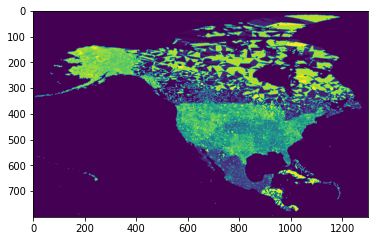

In [245]:
plt.imshow(neargrid_loc[:,:,3])